# What kind of tables contain sequences of ordered dates?

- How many tables have ordered dates, and what is their regularity?
- Do different page entity types have tables with different date distributions?
- 


In [69]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('precision', 2)

In [70]:
# This is the script, but use the stand-alone file.
import pandas as pd
import numpy as np
import qddate, re, datetime, csv, sys
from collections import Counter
parser = qddate.DateParser()
def date(s):
    try:
        return parser.parse(s)
    except:
        pass
def year(s):
    if re.match('^\d{4}$', s):
        return datetime.datetime(int(s), 1, 1)
def season(s):
    if re.match('^\d{4}-\d{2}$', s) and (int(s[-2:])-1 == int(s[2:4]) ):
        return datetime.datetime(int(s[:4]), 1, 1)
    
import json
headers = [
    '_id', 'type', 'sorting', 'top_delta', 'top_freq',
    'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'
]

fw = sys.stdout

dw = csv.DictWriter(fw, headers)
dw.writeheader()

i = 0
for line in open('./data/tables.json'):
    table = json.loads(line)
    _id = table['_id']
    body = [[cell.get('text','') for cell in row] for row in table['tableData']]
    cols = list(zip(*body))
    for c, col in enumerate(cols):
        l = len(col)
        for name, typ in {'date':date,'year':year,'season':season}.items():
            trymap = [typ(s) for s in col]
            if sum(1 for t in trymap if t != None)/l > .5 and len(set(col))>1:
                times = [t for t in trymap if t != None]

                deltas = [(times[di]-dt).total_seconds() for di,dt in enumerate(times[1:])]
                asc, desc  = all(d<=0 for d in deltas), all(d>=0 for d in deltas)
                sorting = 'asc' if asc else ('desc' if desc else 'none')
                top_delta, top_freq = Counter(deltas).most_common(1)[0]

                dw.writerow({
                    '_id':_id, 'type':name, 
                    'sorting':sorting, 'top_delta':top_delta, 'top_freq':top_freq,
                    **dict(pd.Series(deltas).describe())
                })

    i+=1
    if i>10: break

_id,type,sorting,top_delta,top_freq,count,mean,std,min,25%,50%,75%,max
10000032-1,year,asc,-126230400.0,6,10.0,-138853440.0,33923403.73865806,-220924800.0,-149882400.0,-126230400.0,-126230400.0,-94694400.0
10000383-1,year,asc,-94694400.0,1,2.0,-205113600.0,156156330.18638727,-315532800.0,-260323200.0,-205113600.0,-149904000.0,-94694400.0
10000383-2,year,asc,-31622400.0,1,4.0,-86788800.0,90647957.68068908,-220924800.0,-102535200.0,-47347200.0,-31600800.0,-31536000.0
10000548-1,date,asc,-2678400.0,1,6.0,-33768000.0,38178024.54313214,-91411200.0,-58924800.0,-18835200.0,-5637600.0,0.0
10000548-1,date,asc,-16502400.0,1,6.0,-36244800.0,37393646.505469345,-90374400.0,-61992000.0,-17539200.0,-15789600.0,0.0


In [133]:
# Load the results
pd.set_option('precision', 2)

df = pd.read_csv('./data/time_seq2.csv')
print('%d rows total %s' % (len(df), dict(df['type'].value_counts())))

second_cols = 'top_delta	mean	std	min	25%	50%	75%	max'.split()
df[second_cols] = df[second_cols].applymap(lambda x: abs(x/365/24/60/60))
df['id_col'] = df['_id'] + '-' + df['col'].map(str)
df = df.drop(columns='col')
df['type'] = df['type'].astype('category')

# What fraction of date intervals is the most frequent one? (i.e. 1 = perfect regular sequence)
df['top_frac'] = df['top_freq'] / df['count']
df['relstd'] = df['std'] / df['mean']
df.loc[df['relstd'] == float('inf'), 'relstd'] = 0

# actually, this filtering step mostly gets rid of NaNs, I think
df = df[(df['mean'] < 100) & (df['std'] < 100) & (df['relstd'] < 100 ) ]
print('%d rows filtered %s' % (len(df), dict(df['type'].value_counts())))

df.head()

333683 rows total {'year': 209596, 'date': 119878, 'season': 4209}
281712 rows filtered {'year': 176380, 'date': 101568, 'season': 3764}


_id  type sorting  top_delta  top_freq  count  mean   std    min  \
0  10000032-1  year     asc       4.00         6   10.0  4.40  1.08   7.01   
1  10000383-1  year     asc       3.00         1    2.0  6.50  4.95  10.01   
2  10000383-2  year     asc       1.00         1    4.0  2.75  2.87   7.01   
3  10000548-1  date     asc       0.08         1    6.0  1.07  1.21   2.90   
4  10000548-1  date     asc       0.52         1    6.0  1.15  1.19   2.87   

    25%   50%   75%  max        id_col  top_frac  relstd  
0  4.75  4.00  4.00  3.0  10000032-1-1      0.60    0.24  
1  8.25  6.50  4.75  3.0  10000383-1-0      0.50    0.76  
2  3.25  1.50  1.00  1.0  10000383-2-0      0.25    1.04  
3  1.87  0.60  0.18  0.0  10000548-1-1      0.17    1.13  
4  1.97  0.56  0.50  0.0  10000548-1-2      0.17    1.03

In [130]:
# df[(df['relstd'] > 100) & (df['relstd'] < 1000)].head(10)
df[(df['type'] == 'date') & (df['50%']>1000)].head(10)

_id  type sorting  top_delta  top_freq  count     mean  std  \
75999    18692480-2  date    desc    3851.20         1    1.0  3851.20  NaN   
78761    18920932-2  date    desc    1900.67         1    1.0  1900.67  NaN   
79765    19012447-2  date     asc    1900.85         1    1.0  1900.85  NaN   
104243   21694895-2  date    desc    1710.18         1    1.0  1710.18  NaN   
162637   27881811-1  date     asc    1875.42         1    1.0  1875.42  NaN   
162639  27881811-12  date    desc    1908.54         1    1.0  1908.54  NaN   
162640  27881811-14  date     asc    1886.11         1    1.0  1886.11  NaN   
162641  27881811-16  date     asc    1886.38         1    1.0  1886.38  NaN   
162644  27881811-20  date    desc    1911.01         1    1.0  1911.01  NaN   
162646  27881811-24  date    desc    1908.38         1    1.0  1908.38  NaN   

            min      25%      50%      75%      max         id_col  top_frac  \
75999   3851.20  3851.20  3851.20  3851.20  3851.20   18692480-2-2       1.0   
78761   1900.67  1900.67  1900.67  1900.67  1900.67   18920932-2-1       1.0   
79765   1900.85  1900.85  1900.85  1900.85  1900.85   19012447-2-1       1.0   
104243  1710.18  1710.18  1710.18  1710.18  1710.18   21694895-2-3       1.0   
162637  1875.42  1875.42  1875.42  1875.42  1875.42   27881811-1-3       1.0   
162639  1908.54  1908.54  1908.54  1908.54  1908.54  27881811-12-3       1.0   
162640  1886.11  1886.11  1886.11  1886.11  1886.11  27881811-14-3       1.0   
162641  1886.38  1886.38  1886.38  1886.38  1886.38  27881811-16-3       1.0   
162644  1911.01  1911.01  1911.01  1911.01  1911.01  27881811-20-3       1.0   
162646  1908.38  1908.38  1908.38  1908.38  1908.38  27881811-24-3       1.0   

        relstd  
75999      NaN  
78761      NaN  
79765      NaN  
104243     NaN  
162637     NaN  
162639     NaN  
162640     NaN  
162641     NaN  
162644     NaN  
162646     NaN

In [132]:
pd.read_csv('data/bhagavatula_wikitables/27881811-20.csv')

Unnamed: 0               Name         Country     Date of birth       Age
0   Youngest    Anna Dementyeva          Russia  28 December 1994  15 years
1     Oldest  Elizabeth Tweddle  United Kingdom          01/04/85  25 years

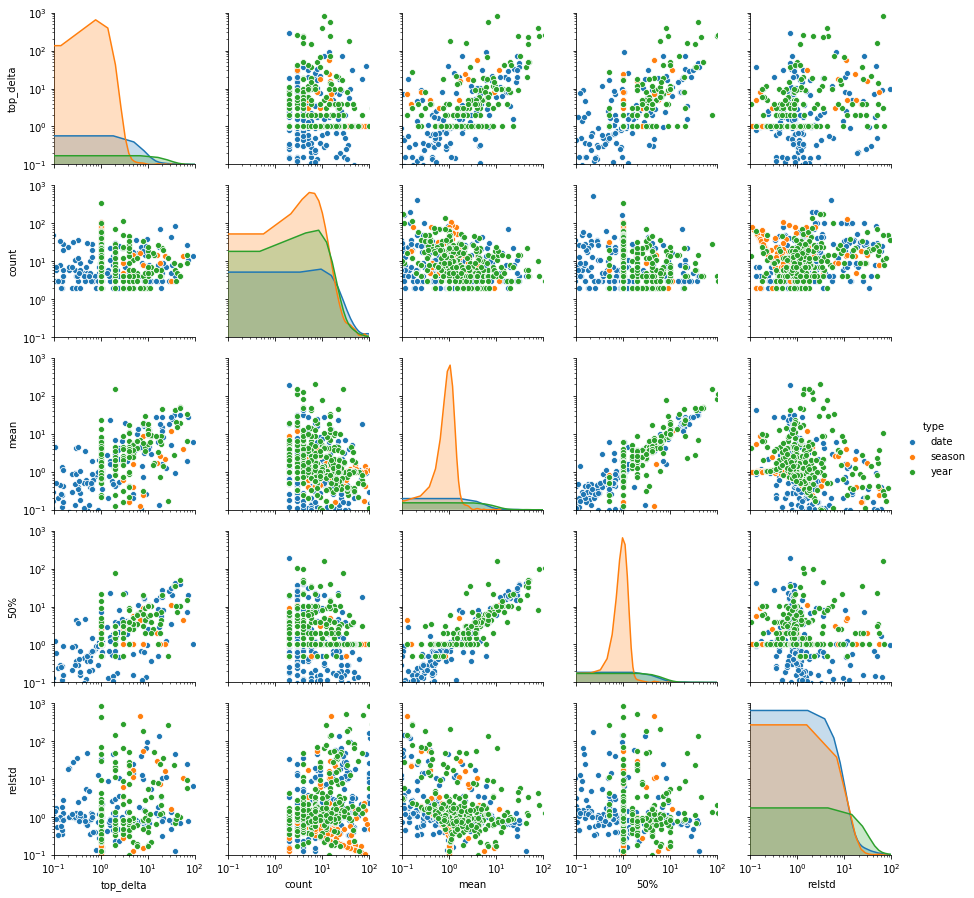

In [74]:
w = df['type'].apply( len(df) / df['type'].value_counts() )
ds = df.sample(n=1000, weights=w)[['type', 'top_delta', 'count', 'mean', '50%', 'relstd']]

g = sns.pairplot(ds, hue='type', diag_kind='kde')
g.set(yscale='log', xscale='log', xlim=[10**-1,10**2], ylim=[10**-1,10**3])

The season-tables mostly have one-year intervals


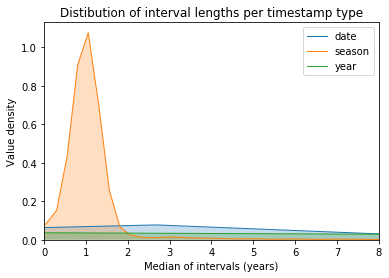

In [126]:
w = df['type'].apply( len(df) / df['type'].value_counts() )
ds = df[~()].sample(n=5000, weights=w)
for lbl, g in ds.groupby('type'):
    sns.distplot(g['50%'], hist = False, kde = True,
        kde_kws = {'shade': True, 'linewidth': 1}, 
        label = lbl)
plt.xlim(0,8)
plt.xlabel('Median of intervals (years)')
plt.ylabel('Value density')
plt.title('Distibution of interval lengths per timestamp type')
plt.savefig('new-entities/img/timestamp-interval-median-density.pdf')
print('The season-tables mostly have one-year intervals')

/export/scratch1/home/kruit/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/export/scratch1/home/kruit/venv/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/export/scratch1/home/kruit/venv/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


ValueError: cannot convert float NaN to integer

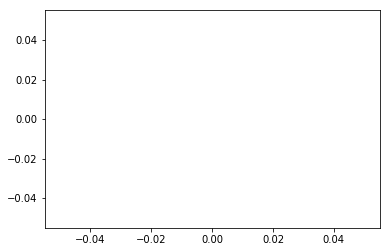

In [120]:
import seaborn as sns
w = df['type'].apply( len(df) / df['type'].value_counts() )
ds = df.sample(n=5000, weights=w)
for lbl, g in ds.groupby('type'):
    sns.distplot(g['relstd'], hist = True, kde = True,
        kde_kws = {'shade': True, 'linewidth': 1}, 
        label = lbl)
plt.xlim(0,10)
plt.xlabel('Relative standard deviation ($\\sigma^2 / \\mu$)')
plt.ylabel('Value density')
plt.title('Distibution of RSD of intervals per timestamp type')
plt.savefig('new-entities/img/timestamp-interval-relstd-density.pdf')
print('The date intervals are much less regular than the others')

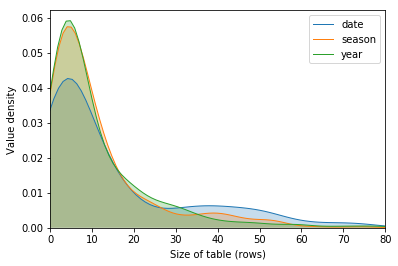

In [115]:
w = df['type'].apply( len(df) / df['type'].value_counts() )
ds = df[df['count'] < 80].sample(n=1000, weights=w)
for lbl, g in ds.groupby('type'):
    sns.distplot(g['count'], hist = False, kde = True,
        kde_kws = {'shade': True, 'linewidth': 1},
        label = lbl)
plt.xlim(0,80)
plt.xlabel('Size of table (rows)')
plt.ylabel('Value density')
None

In [77]:
print('%.2f of tables has some regularity' % (sum(df['top_freq'] != 1) / len(df)))
print('%.2f of tables is fully regular' % (sum(df['std'] == 0) / len(df)))

0.61 of tables has some regularity
0.03 of tables is fully regular


[None, (1, 100)]

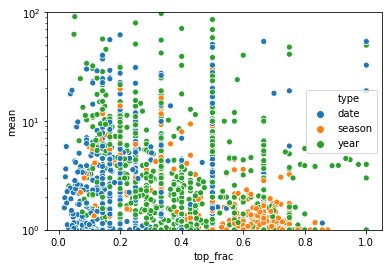

In [146]:
import seaborn as sns
w = df['type'].apply( len(df) / df['type'].value_counts() )
df_ = df.sample(n=5000, weights=w)

sns.scatterplot('top_frac','mean',data=df_, hue='type').set(yscale='log', ylim=[1,10**2])

In [155]:
df[(df['count'] == 100) & (df['type'] == 'date')].head()

_id  type sorting  top_delta  top_freq  count  mean       std  \
590    10062725-4  date    none   1.92e-02        39  100.0  0.03  1.30e-01   
9195   11100042-2  date     asc   2.74e-03        49  100.0  0.01  8.73e-03   
14082  11677694-7  date    none   2.79e-01         2  100.0  0.10  4.14e+00   
25194   1282231-1  date    none   0.00e+00        22  100.0  0.10  2.77e+00   
40197  14460786-1  date     asc   0.00e+00        51  100.0  0.03  4.66e-02   

        min   25%       50%       75%    max        id_col  top_frac  relstd  
590    0.38  0.05  1.92e-02  1.92e-02   0.98  10062725-4-1      0.39    3.83  
9195   0.05  0.02  2.74e-03  2.74e-03   0.00  11100042-2-2      0.49    0.87  
14082  7.94  3.61  2.79e-01  2.57e+00   9.11  11677694-7-2      0.02   43.13  
25194  5.31  0.58  0.00e+00  4.38e-01  13.45   1282231-1-2      0.22   28.26  
40197  0.22  0.04  0.00e+00  0.00e+00   0.00  14460786-1-1      0.51    1.60

In [33]:
tables = pd.read_csv('data/tables.csv')
tables.head()

Unnamed: 0         _id  nrows_identical  numCols  numDataRows  \
0           0  10000032-1                0        4           11   
1           1   1000006-1                0        4           21   
2           2  10000088-1                2        2            1   
3           3  10000218-1                0        2            6   
4           4  10000228-1                0        2            7   

   numHeaderRows numericColumns  order      pgId  \
0              1            [1]   0.54  10000032   
1              1             []   0.86   1000006   
2              3             []   0.32  10000088   
3              1             []   0.55  10000218   
4              1            [1]   0.95  10000228   

                                             pgTitle  \
0  Mid Antrim (Northern Ireland Parliament consti...   
1                                     Römer (crater)   
2                                        Whispermoon   
3                     Khalsa Diwan Society Vancouver   
4                                    Julien Leparoux   

                sectionTitle               tableCaption  tableId  
0      Members of Parliament      Members of Parliament        1  
1          Satellite craters          Satellite craters        1  
2                        NaN              Track listing        1  
3  First executive committee  First executive committee        1  
4            Year-end charts            Year-end charts        1